This notebook explores ideas from **Generative Thermodynamic Computing**  
([Whitelam, 2025](https://arxiv.org/abs/2506.15121v2)).


The potential energy of the thermodynamic computer is given by

$$
V_\theta(x) 
= \sum_{i=1}^N \left( J_2 x_i^2 + J_4 x_i^4 \right) 
+ \sum_{i=1}^N b_i x_i 
+ \sum_{(i,j)} J_{ij} x_i x_j .
$$

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as w

# Parameters
#J2 = 1.0
#J4 = 0.1

b = np.array([0.5, -0.3])   # biases
J = np.array([[0.0, -1.0],  # couplings
              [-1.0, 0.0]])

def V_theta(x1, x2, J2, J4):
    
    x = np.array([x1, x2])
    
    term_quadratic = J2 * np.sum(x**2)
    term_quartic = J4 * np.sum(x**4)
    term_linear  = np.dot(b, x)
    term_interactions = np.dot(x, J @ x) / 2.0 # divide by 2 to avoid double counting (assuming J is symmetric)
            
    return term_quadratic + term_quartic + term_linear + term_interactions

def plot_energy(J2, J4):
    x1_vals = np.linspace(-2, 2, 200)
    x2_vals = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    
    V = np.vectorize(lambda x1, x2: V_theta(x1, x2, J2, J4))(X1, X2)

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X1, X2, V, cmap="viridis", alpha=0.9)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    #ax.set_zlabel("$V_\\theta$")
    ax.set_title(f"Energy landscape with J2={J2:.1f}, J4={J4:.1f}")
    
w.interact(plot_energy,
           J2=w.FloatSlider(value=1.0, min=-5, max=5, step=0.1, description="J2"),
           J4=w.FloatSlider(value=1.0, min=-5, max=5, step=0.1, description="J4"))


interactive(children=(FloatSlider(value=1.0, description='J2', max=5.0, min=-5.0), FloatSlider(value=1.0, desc…

<function __main__.plot_energy(J2, J4)>

## Experiment Replication

In [67]:
import math, random, os, sys
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [69]:
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # flatten 28x28 → 784
    transforms.Lambda(lambda v: (v - v.mean()) / (v.std() + 1e-8))
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)

def sample_digit(digit, device="cpu"):
    
    idxs = [i for i, (_, y) in enumerate(mnist) if y == digit]
    i = random.choice(idxs)     
    v, y = mnist[i]
    return v.view(-1).to(device)
     

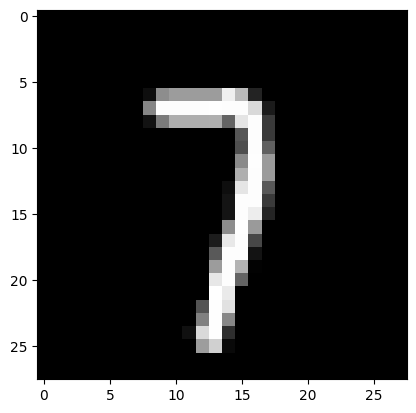

In [70]:
plt.imshow(sample_digit(7).view(28,28), cmap="gray")
plt.show()

In [71]:
# Constants
kBT = 1.0
mu = 1.0
J2 = 10.0
J4 = 10.0

# Chosen through trial and error
bias_scale = 20.0

Nv = 28*28  # number of visible units
Nh = 512     # number of hidden units

J_vh = torch.zeros(Nv, Nh, device=device)   # visible-to-hidden couplings
J_hh = torch.zeros(Nh, Nh, device=device)   # hidden-to-hidden couplings
b_h  = torch.zeros(Nh, device=device)       # hidden biases
# no visible-to-visible couplings

def energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh):
  
    b_v = b_v.to(x_v.device)
    b_h = b_h.to(x_h.device)
    
    # Computer V_theta(x) and its gradients (autograd)
    x_v = x_v.clone().detach().requires_grad_(True)
    x_h = x_h.clone().detach().requires_grad_(True)
    
    # Energy terms
    V = J2*(x_v.pow(2).sum() + x_h.pow(2).sum()) \
      + J4*(x_v.pow(4).sum() + x_h.pow(4).sum()) 
    V = V + (b_v @ x_v) + (b_h @ x_h) 
    V = V + (x_v @ J_vh @ x_h) + 0.5*(x_h @ J_hh @ x_h)
    
    V.backward()

    g_v = x_v.grad.detach()
    g_h = x_h.grad.detach()

    return V.item(), g_v, g_h

In [72]:
def euler_maruyama_step(x_v, x_h, b_v, b_h, J_vh, J_hh, dt, kBT=1.0, mu=1.0):
    
    # Compute energy and gradients
    V, g_v, g_h = energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh)
    
    # Gaussian noise
    noise_v = torch.randn_like(x_v)
    noise_h = torch.randn_like(x_h)
    
    sigma = torch.sqrt(torch.tensor(2.0 * mu * kBT * dt, device=x_v.device, dtype=x_v.dtype))

    # Euler-Maruyama update
    x_vn = x_v - mu * g_v * dt + sigma * noise_v
    x_hn = x_h - mu * g_h * dt + sigma * noise_h
    
    return  x_vn, x_hn, V
    

In [73]:
# Projection (Random Projection) 
# TODO: try alternatives
U = torch.randn(Nh, Nv, device=device) / math.sqrt(Nv)

def fade_schedule(k: int, K: int) -> float:
    """Linear fade from 1 → 0 over K steps."""
    return 1.0 - (k / K)

def visible_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * P).to(P.device)

def hidden_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * (U @ P)).to(P.device)

In [74]:
# Forward noising trajectory

def run_noising_trajectory(P, tf=2.5, dt=1e-3, snapshots=12, t_eq=0.5, use_trainable=False):
    
    K = int(tf / dt)
    snap_every = max(1, K // snapshots)
    
    if use_trainable:
        Jvh, Jhh = J_vh, J_hh   # trainable parameters
    else:
        Jvh = torch.zeros_like(J_vh)
        Jhh = torch.zeros_like(J_hh)
    
    x_v = torch.randn(Nv, device=device)
    x_h = torch.randn(Nh, device=device)


    states_all = []
    vis_snaps = []
    
    # Bias is scaled (why?)

    # Reach equilibrium
    K_eq = int(t_eq / dt)
    for _ in range(K_eq):
        b_v = (P * bias_scale).to(P.device)
        b_h = ((U @ P) * bias_scale).to(P.device)    
        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, Jvh, Jhh, dt, kBT, mu)

    states_all.append((x_v.clone(), x_h.clone()))
    for k in range(K):
        b_v = visible_bias_schedule(P, k, K, scale=bias_scale)
        b_h = hidden_bias_schedule(P, k, K, scale=bias_scale)

        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, Jvh, Jhh, dt, kBT, mu)

        states_all.append((x_v.clone(), x_h.clone()))
        
        if k % snap_every == 0 or k == K - 1:
            vis_snaps.append(x_v.clone())

        #if k % (K // 10) == 0:
           #print(f"Step {k}/{K}, V={V:.2f}")

    return states_all, vis_snaps
    

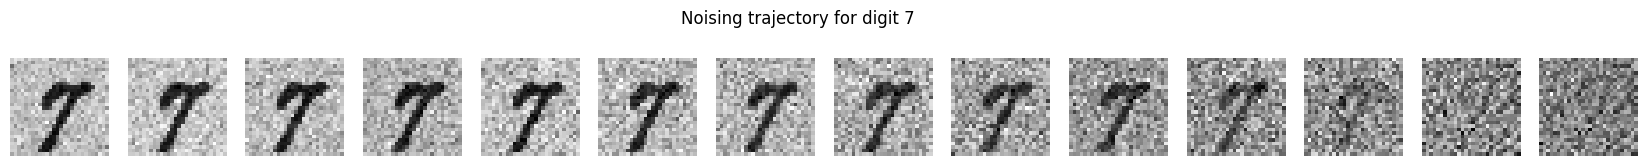

In [75]:
digit_id = 7
P = sample_digit(digit_id)

_, snaps = run_noising_trajectory(P, tf=2.5, dt=1e-3, snapshots=12)


plt.figure(figsize=(1.5*len(snaps), 2))
for i, state in enumerate(snaps):
    ax = plt.subplot(1, len(snaps), i+1)
    ax.imshow(state.view(28, 28).detach().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle(f"Noising trajectory for digit {digit_id}")
plt.show()

In [76]:
# Reverse step negative log-likelihood



def reverse_step_nll(
    x_v, x_h,                # state at time t
    x_v_next, x_h_next,      # state at time t+dt (x')
    J_vh, J_hh, b_h,         # trainable params of the reverse model
    dt, mu=1.0, kBT=1.0, J2=10.0, J4=10.0
):

    b_v_trainable = torch.zeros_like(x_v_next)  # no visible bias in the reverse model
    _, g_v_next, g_h_next = energy_and_grad(
        x_v_next, x_h_next, b_v_trainable, b_h, J_vh, J_hh
    )
    
    dx_v = x_v_next - x_v
    dx_h = x_h_next - x_h
    
    r_v = -dx_v + mu * g_v_next * dt
    r_h = -dx_h + mu * g_h_next * dt
    
    denominator = 4.0 * mu * kBT * dt
    nll = (r_v.pow(2).sum() + r_h.pow(2).sum()) / denominator
    
    s_v = r_v / (2.0 * kBT)
    s_h = r_h / (2.0 * kBT)
    
    return nll, (s_v, s_h), (x_v_next, x_h_next)
    


In [77]:
def reverse_step_gradients(s_v, s_h, x_v_next, x_h_next):
    
    # Visible–hidden couplings (Nv x Nh)
    grad_Jvh = torch.einsum("i,j->ij", s_v, x_h_next) \
             + torch.einsum("i,j->ij", x_v_next, s_h)

    # Hidden–hidden couplings (Nh x Nh)
    outer = torch.einsum("i,j->ij", s_h, x_h_next)
    grad_Jhh = 0.5 * (outer + outer.T)

    # Hidden biases 
    grad_bh = s_h.clone()
    
    return grad_Jvh, grad_Jhh, grad_bh
    


In [ ]:
P = sample_digit(0)

def train_model(num_epochs=1, num_digits=100, dt=1e-3, lr=1e-3):
    global J_vh, J_hh, b_h 
    
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

        for d in range(num_digits):
            
            #P = sample_digit(0)

            states_all, _ = run_noising_trajectory(P, tf=0.5, dt=dt, use_trainable=False)

            total_nll = 0.0
            grad_Jvh_accum = torch.zeros_like(J_vh)
            grad_Jhh_accum = torch.zeros_like(J_hh)
            grad_bh_accum  = torch.zeros_like(b_h)

            num_steps = len(states_all) - 1
            for step, ((x_v, x_h), (x_v_next, x_h_next)) in enumerate(zip(states_all[:-1], states_all[1:])):
                nll, (s_v, s_h), (xv_next, xh_next) = reverse_step_nll(
                    x_v, x_h, x_v_next, x_h_next,
                    J_vh, J_hh, b_h, dt, mu, kBT, J2, J4
                )
                dJvh, dJhh, dbh = reverse_step_gradients(s_v, s_h, xv_next, xh_next)

                total_nll += nll.detach()
                grad_Jvh_accum += dJvh
                grad_Jhh_accum += dJhh
                grad_bh_accum  += dbh

                if step % (num_steps // 5) == 0:
                    print(f"  Digit {d+1}/{num_digits}, Step {step}/{num_steps}, NLL={nll.item():.2f}")

            J_vh -= lr * grad_Jvh_accum
            J_hh -= lr * grad_Jhh_accum
            b_h  -= lr * grad_bh_accum
            
            print("||J_vh||:", J_vh.norm().item(),
            "||J_hh||:", J_hh.norm().item(),
            "||b_h||:", b_h.norm().item())



            avg_nll = (total_nll / num_steps).item()
            epoch_loss += avg_nll

        # average loss per digit
        epoch_loss /= num_digits
        losses.append(epoch_loss)

        normalized_loss = epoch_loss / (Nv + Nh)
        print(f"Epoch {epoch+1}/{num_epochs} complete | Avg NLL={epoch_loss:.2f}, Normalized={normalized_loss:.4f}")

    return J_vh, J_hh, b_h, losses


In [ ]:
'''

# Compare manual and autograd gradients

J_vh = torch.randn(Nv, Nh, device=device, requires_grad=True) * 0.01
J_hh = torch.randn(Nh, Nh, device=device, requires_grad=True) * 0.01
b_h  = torch.zeros(Nh, device=device, requires_grad=True)

P = sample_digit(0)
states_all, _ = run_noising_trajectory(P, tf=0.1, dt=1e-4, use_trainable=False)

x_v, x_h = states_all[0]
x_v_next, x_h_next = states_all[1]


nll, (s_v, s_h), (xv_next, xh_next) = reverse_step_nll(
    x_v, x_h, x_v_next, x_h_next,
    J_vh, J_hh, b_h, dt=1e-4, mu=mu, kBT=kBT, J2=J2, J4=J4
)

# Autograd gradients
grads = torch.autograd.grad(nll, [J_vh, J_hh, b_h], retain_graph=True, allow_unused=True)
grad_Jvh_auto, grad_Jhh_auto, grad_bh_auto = grads

# Manual gradients
grad_Jvh_manual, grad_Jhh_manual, grad_bh_manual = reverse_step_gradients(s_v, s_h, xv_next, xh_next)

print("Auto vs Manual norms:")
print("J_vh:", grad_Jvh_auto.norm().item(), grad_Jvh_manual.norm().item())
print("J_hh:", grad_Jhh_auto.norm().item(), grad_Jhh_manual.norm().item())
print("b_h :", grad_bh_auto.norm().item(),  grad_bh_manual.norm().item())
'''

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [83]:
J_vh = torch.randn(Nv, Nh, device=device) * 0.01 / np.sqrt(Nv + Nh)
J_hh = torch.randn(Nh, Nh, device=device) * 0.01 / np.sqrt(Nh)
J_hh = 0.5 * (J_hh + J_hh.T)  
b_h = torch.zeros(Nh, device=device)

J_vh, J_hh, b_h, losses = train_model(
    num_epochs=2,     
    num_digits=1,     
    dt=1e-4,         
    lr=3e-3 
)     


=== Epoch 1/2 ===
  Digit 1/1, Step 0/5000, NLL=671.40
  Digit 1/1, Step 1000/5000, NLL=634.24
  Digit 1/1, Step 2000/5000, NLL=638.17
  Digit 1/1, Step 3000/5000, NLL=675.51
  Digit 1/1, Step 4000/5000, NLL=641.44
||J_vh||: 3.8634495735168457 ||J_hh||: 1.6488209962844849 ||b_h||: 0.1966570019721985
Epoch 1/2 complete | Avg NLL=652.45, Normalized=0.5034

=== Epoch 2/2 ===
  Digit 1/1, Step 0/5000, NLL=667.10
  Digit 1/1, Step 1000/5000, NLL=602.29
  Digit 1/1, Step 2000/5000, NLL=634.93
  Digit 1/1, Step 3000/5000, NLL=647.31
  Digit 1/1, Step 4000/5000, NLL=696.75
||J_vh||: 8.182855606079102 ||J_hh||: 3.5390000343322754 ||b_h||: 0.42371857166290283
Epoch 2/2 complete | Avg NLL=654.73, Normalized=0.5052


In [ ]:
torch.save({
    "J_vh": J_vh,
    "J_hh": J_hh,
    "b_h": b_h,
    "losses": losses
}, "thermo_gen_model_test.pth")


In [1]:
def run_generation(J_vh, J_hh, b_h, tf=2.5, dt=1e-3, snapshots=12):
    
    K = int(tf / dt)
    snap_every = max(1, K // snapshots)

    x_v = torch.randn(Nv)
    x_h = torch.randn(Nh)

    vis_states = []

    for k in range(K):
        b_v = torch.zeros(Nv)  

        x_v, x_h, V = euler_maruyama_step(
            x_v, x_h, b_v, b_h, J_vh, J_hh, dt, kBT, mu
        )

        if k % snap_every == 0 or k == K - 1:
            vis_states.append(x_v.clone())

    return vis_states

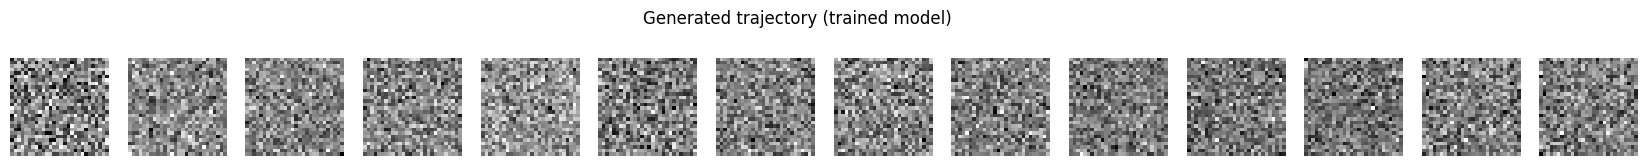

In [ ]:
samples = run_generation(J_vh, J_hh, b_h, tf=2.5, dt=1e-3, snapshots=12)

plt.figure(figsize=(1.5*len(samples), 2))
for i, state in enumerate(samples):
    ax = plt.subplot(1, len(samples), i+1)
    ax.imshow(state.view(28, 28).detach().numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated trajectory (trained model)")
plt.show()